In [1]:
import os
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner

In [2]:
def gaussian(x, mu, sigma):
    return (1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2)))

In [3]:
# Importance sampling for cluster samples
def likelihood_singleIMBH(x, mu0, sigma0, file):
    mu, sigma = x
    z1 = file['zcl0_1']
    z2 = file['zcl0_2']
    
    z1_gaussian = gaussian(z1, mu, sigma)
    z2_gaussian = gaussian(z2, mu, sigma)
    
    x_z1_gaussian = gaussian(z1, mu0, sigma0)
    x_z2_gaussian = gaussian(z2, mu0, sigma0)
 
    return 1/len(z1) * np.sum((z1_gaussian * z2_gaussian) / (x_z1_gaussian * x_z2_gaussian))

In [4]:
# Product for all IMBHs
def log_likelihood(x, mu0, sigma0, data):
    log_likelihoods = [
        np.log(likelihood_singleIMBH(x, mu0, sigma0, file))
        for file in data
    ]
    log = np.array(log_likelihoods)
    return np.sum(log)

In [5]:
def log_prior(mu, sigma):
    if 0 < mu < 15.0 and 0 < sigma < 15.0:
        return 0.0
    return -np.inf

In [6]:
def log_probability(x, x0, data):
    mu, sigma = x
    mu0, sigma0 = x0
    lp = log_prior(mu, sigma)
    if not np.isfinite(lp):
        return -np.inf
    return lp * len(data) + log_likelihood(x, mu0, sigma0, data)

In [7]:
directory = './tid_lowz_003_few/'
data = [
    np.load(os.path.join(directory, filename))
    for filename in os.listdir(directory)
    if os.path.isfile(os.path.join(directory, filename)) and filename.endswith('.npz')
]

mu0 = 3.2
sigma0 = 1.5
x0 = [mu0, sigma0]

ndim = 2
nwalkers = 4
pos = [x0 + 1e-1*np.random.randn(ndim) for i in range(nwalkers)]
pos

[array([3.38235144, 1.54546257]),
 array([3.26406369, 1.51316851]),
 array([3.16434229, 1.38802338]),
 array([3.20400608, 1.59849234])]

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x0, data))
sampler.run_mcmc(pos, 5000, progress=True)

100%|█████████████████████████████████████| 5000/5000 [1:38:17<00:00,  1.18s/it]


State([[13.20716557  1.8416955 ]
 [13.21053745  1.83979193]
 [13.18880016  1.85533471]
 [13.22153719  1.818365  ]], log_prob=[35700.85560462 35700.8056148  35700.99664351 35700.03924133], blobs=None, random_state=('MT19937', array([2233404233,  675218153, 3199137442,   26494361,  859001672,
       1062453816, 2256591954, 2053093119, 3731697283,  635086592,
       3907032839, 3349585403, 2479633961, 2044369299,  466173196,
        634971342, 2650752819,  721483646,  260283988, 2194696785,
       2620160238, 1570785761, 2048771410, 3428022736, 3430045303,
       2696314197, 2976739917, 1789158658, 3793922202, 4077361158,
       1770445086, 1199622666, 3305704376, 4258410643, 2236803943,
       2922698591, 2403367256, 3814546215, 3326523798, 1697985241,
       3447712217, 4076778088, 3296532963,  529190179,  834475535,
        467762945, 3849983520, 1400238783, 3284051133, 1773116995,
       3407400276, 1124623315, 3413504762, 1489722282, 1560636659,
        692845860,  597846580, 2202155

(0.0, 500.0)

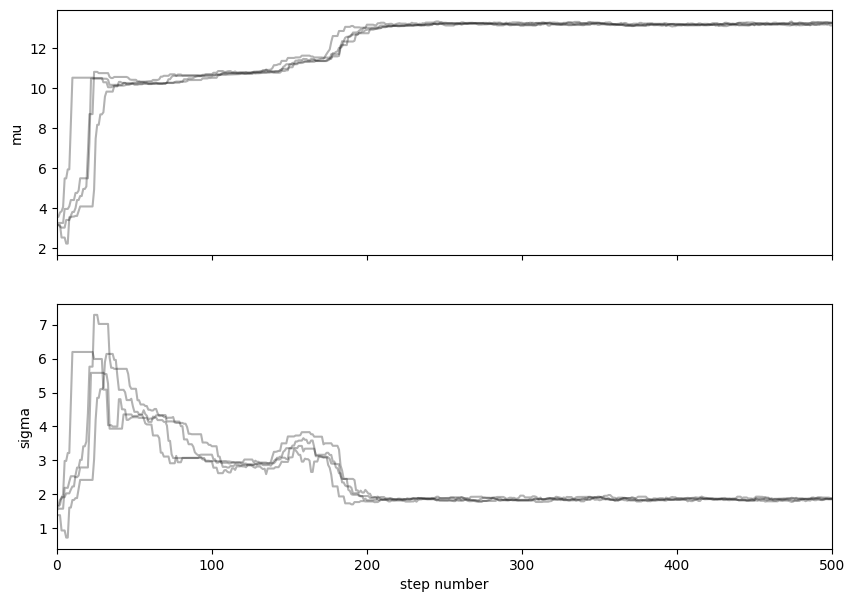

In [10]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["mu", "sigma"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");
plt.xlim(0,500)

In [11]:
samples = sampler.get_chain(discard=200, thin=10, flat=True)

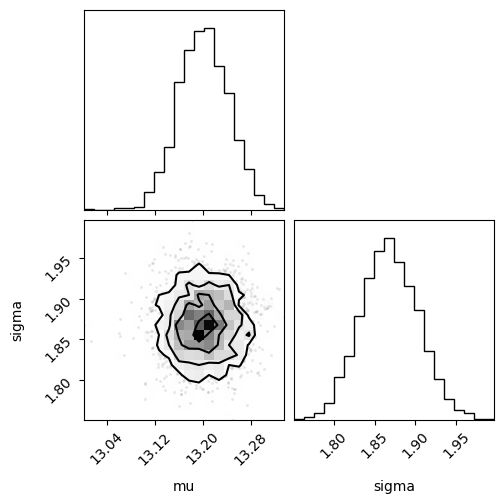

In [12]:
fig = corner.corner(samples, labels=["mu", "sigma"], truths=x0)
plt.show()

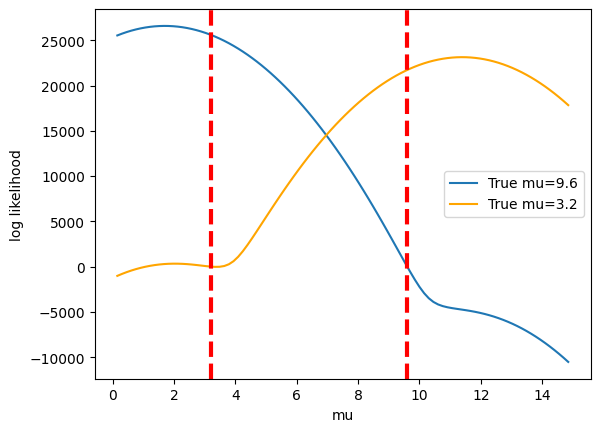

In [13]:
directory = './tid_lowz_003/'
data = [
    np.load(os.path.join(directory, filename))
    for filename in os.listdir(directory)
    if os.path.isfile(os.path.join(directory, filename)) and filename.endswith('.npz')
]

mu = np.linspace(0, 15, 100)
sigma = 1.5 * np.ones(100)
x = np.array([mu, sigma])
x = np.transpose(x)

x0 = [9.6, 1.5]
lp = [log_probability(x1, x0, data) for x1 in x]
plt.plot(mu, lp, label='True mu=9.6')

x0 = [3.2, 1.5]
lp = [log_probability(x1, x0, data) for x1 in x]
plt.plot(mu, lp, color='orange', label='True mu=3.2')
plt.legend()
plt.axvline(3.2, color='red', lw=3, linestyle='dashed')
plt.axvline(9.6, color='red', lw=3, linestyle='dashed')

plt.xlabel('mu')
plt.ylabel('log likelihood')
plt.savefig('mc_likelihood.png', dpi=200)

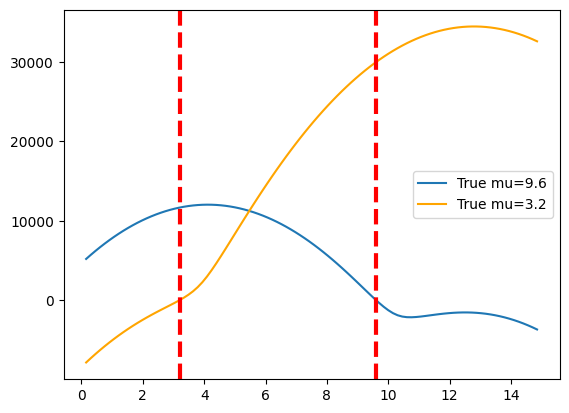

In [14]:
directory = './tid_highz_003/'
data = [
    np.load(os.path.join(directory, filename))
    for filename in os.listdir(directory)
    if os.path.isfile(os.path.join(directory, filename)) and filename.endswith('.npz')
]

mu = np.linspace(0, 15, 100)
sigma = 1.5 * np.ones(100)
x = np.array([mu, sigma])
x = np.transpose(x)

x0 = [9.6, 1.5]
lp = [log_probability(x1, x0, data) for x1 in x]
plt.plot(mu, lp, label='True mu=9.6')

x0 = [3.2, 1.5]
lp = [log_probability(x1, x0, data) for x1 in x]
plt.plot(mu, lp, color='orange', label='True mu=3.2')
plt.legend()
plt.axvline(3.2, color='red', lw=3, linestyle='dashed')
plt.axvline(9.6, color='red', lw=3, linestyle='dashed')